<a href="https://colab.research.google.com/github/Glasiermedic/Boosting-examples/blob/master/3_5_3_Guided_example_and_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

### Gradient boost guided example

Having walked through gradient boost by hand, now let's try it with SKlearn.  We'll still use the European Social Survey Data, but now with a categorical outcome: Whether or not someone lives with a partner.

In [0]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]
print (X.head(10))
#X = X.drop(['tvtot', 'pplfair', 'ppltrst', 'sclact', 'pplhlp', 'year'], axis = 1)

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)
X['people']= (df['ppltrst'] + df['pplfair'] + df['pplhlp'])/3
X['school']= (df['sclmeet'] + df['sclact'])/2
X = X.drop(['tvtot', 'pplfair', 'ppltrst', 'sclact', 'sclmeet', 'pplhlp', 'year'], axis = 1)
X.agea = (X.agea)/10 
# Create training and test sets.
offset = int(X.shape[0] * 0.9)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)


print (X.head(10))


    year  tvtot  ppltrst  pplfair  pplhlp  happy  sclmeet  sclact  gndr  agea
0      6    3.0      3.0     10.0     5.0    8.0      5.0     4.0   2.0  60.0
1      6    6.0      5.0      7.0     5.0    9.0      3.0     2.0   2.0  59.0
2      6    1.0      8.0      8.0     8.0    7.0      6.0     3.0   1.0  24.0
3      6    4.0      6.0      6.0     7.0   10.0      6.0     2.0   2.0  64.0
4      6    5.0      6.0      7.0     5.0    8.0      7.0     2.0   2.0  55.0
6      6    3.0      0.0      5.0     2.0    0.0      2.0     2.0   1.0  76.0
7      6    2.0      4.0      5.0     3.0   10.0      5.0     2.0   2.0  30.0
8      6    2.0      8.0      8.0     8.0    9.0      6.0     4.0   2.0  84.0
9      6    4.0      4.0      4.0     8.0    7.0      4.0     2.0   2.0  62.0
10     6    1.0      6.0      7.0     7.0    9.0      5.0     2.0   2.0  33.0
    happy  gndr  agea  CH  CZ  DE  ES  NO  SE    people  school
0     8.0   2.0   6.0   1   0   0   0   0   0  6.000000     4.5
1     9.0   2.

Since we're now working with a binary outcome, we've switched to a classifier.  Now our loss function can't be the residuals.  Our options are "deviance", or "exponential".  Deviance is used for logistic regression, and we'll try that here. 

In [0]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 1000,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.04582651391162029
Percent Type II errors: 0.17757774140752863

Test set accuracy:
Percent Type I errors: 0.05766871165644172
Percent Type II errors: 0.17791411042944785


### Original accuracy:
#### Goal is to get the smallest type I and II errors

#### Percent Type I errors: 0.04650845608292417

#### Percent Type II errors: 0.17607746863066012

#### Test set accuracy:
#### Percent Type I errors: 0.06257668711656442

#### Percent Type II errors: 0.18527607361963191




## Improved Model

#### To fine tune the model we increased the number of estimators used, created a 'school' feature by combining the two school features into an average of both.  We also created a 'people' feature by combining the three people features into an average of them all.  

#### Training set accuracy:
#### Percent Type I errors: 0.04582651391162029
#### Percent Type II errors: 0.17757774140752863

#### Test set accuracy:
#### Percent Type I errors: 0.05766871165644172
#### Percent Type II errors: 0.17791411042944785



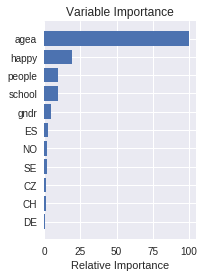

In [0]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

It appears that age and happiness are the most important features in predicting whether or not someone lives with a partner.

### DRILL: Improve this gradient boost model

While this model is already doing alright, we've seen from the Type I and Type II error rates that there is definitely room for improvement.  Your task is to see how low you can get the error rates to go in the test set, based on your model in the training set.  Strategies you might use include:

* Creating new features
* Applying more overfitting-prevention strategies like subsampling
* More iterations
* Trying a different loss function
* Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

Have fun!